In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('data/sample_submission.csv')
num_feature = df.columns.drop(['id', 'target'])
target = 'target'
df.target = df.target.clip(7,20)

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
df = df.iloc[~df.index.isin(lowest_quality_labels)]

df = df[df.target != 7]

In [80]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

import numpy as np

def standardize_data(data):
    """
    Standardize the input data (Z-score normalization).

    Parameters:
    - data (np.array): Input data to be standardized.

    Returns:
    - np.array: Standardized data.
    """
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    
    # Avoid division by zero by adding a small epsilon
    std_dev += 1e-7
    
    standardized_data = (data - mean) / std_dev
    return standardized_data

# Assuming the other parts of your code and the provided CustomDataset are above this
col_to_keep = ['O2_1', 'target']
training_df = df[col_to_keep]
training_ds = CustomDataset(training_df)

# Convert CustomDataset to a numpy matrix
training_data_matrix = np.array([sample.astype(np.float32) for sample in training_ds])
training_df = pd.DataFrame(training_data_matrix)
training_ds = CustomDataset(training_df)

# Normalize the data matrix
normalized_data_matrix = standardize_data(training_data_matrix)

# Create a new CustomDataset with normalized data
normalized_df = pd.DataFrame(normalized_data_matrix)
normalized_training_ds = CustomDataset(normalized_df)


In [83]:
import torch as T
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(T.nn.Module):
    def __init__(self, input_dim=2, encoding_dim=32, dropout_rate=0.5):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, encoding_dim),
            nn.Sigmoid()  # Consider Tanh or other activations if encoding can be negative
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)
# Define the model
autoencoder = AutoEncoder(input_dim=2, encoding_dim=64, dropout_rate=0.0).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)  # Reduce LR every 30 epochs by 70%

cpu


Epoch 100/100, Loss: 0.8305

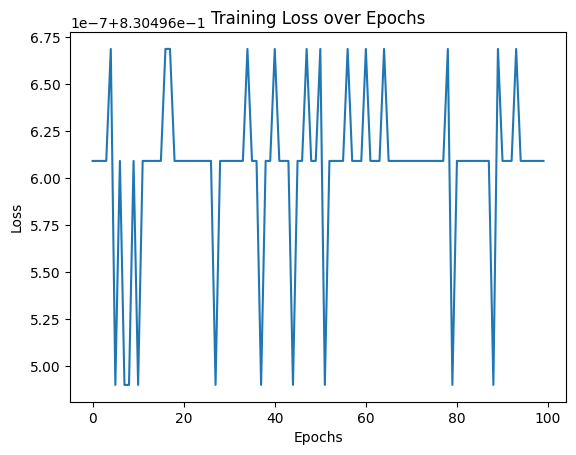

In [91]:
def train(model, dataset, num_epochs=50, batch_size=32):
    dataloader = T.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_values = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data in dataloader:
            data = data.to(device)  # Send data to GPU
            outputs = model(data)
            loss = loss_function(outputs, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        scheduler.step()  
        average_epoch_loss = epoch_loss / len(dataloader)
        loss_values.append(average_epoch_loss)
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_epoch_loss:.4f}')
        print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}', end='')


    # Plotting
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

train(autoencoder, normalized_training_ds, num_epochs=100, batch_size=2983)

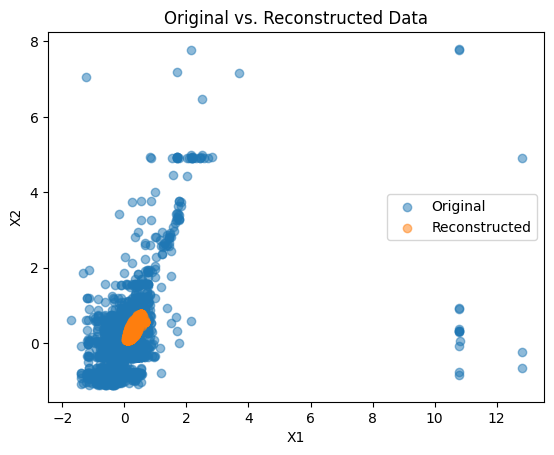

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# # Use DataLoader to handle the data transformation from Dataset to Tensor
dataloader_eval = T.utils.data.DataLoader(normalized_training_ds, batch_size=len(normalized_training_ds), shuffle=False)

# # Pass data through the autoencoder
reconstructed_data = []
# autoencoder.eval()
# with T.no_grad():
#     for data in dataloader_eval:
#         data_gpu = data.to(device)  # Ensure data is on GPU
#         recon = autoencoder(data_gpu)
#         reconstructed_data.append(recon.cpu())

# reconstructed_data = T.cat(reconstructed_data).numpy()


import matplotlib.pyplot as plt
import numpy as np

# Assuming the data can be visualized in a 2D scatter plot.
# Let's say the data has 4 dimensions, and you'd like to visualize the first 2 dimensions.

# Convert the original data to numpy directly from the CustomDataset object
original_data = normalized_training_ds.data

autoencoder.eval()
# Visualize the results
with torch.no_grad():
    for data in dataloader_eval:
        outputs = autoencoder(data)
        reconstructed_data.append(outputs)
        
    reconstructed_data = T.cat(reconstructed_data).numpy()
    plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
    plt.title("Original vs. Reconstructed Data")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()




In [97]:
reconstructed_data

array([[0.58829665, 0.505324  ],
       [0.20968616, 0.168745  ],
       [0.15639469, 0.13003619],
       ...,
       [0.2795052 , 0.5412379 ],
       [0.41234428, 0.5191317 ],
       [0.1897697 , 0.17904209]],
      dtype=float32)

In [99]:
normalized_df.describe(include='all')

,0,1
count,2840.000000,2840.000000
mean,0.000009,0.000012
std,1.000175,1.000176
min,-1.732314,-1.115553
25%,-0.369805,-0.779179
50%,-0.137181,-0.161349
75%,0.328066,0.332915
max,12.806661,7.801796


In [107]:
# Select the first column of normalized_df
normalized_df.iloc[:, 0]

0       1.701542
1       0.095442
2      -0.120565
3      -0.303341
4      -0.353189
          ...   
2835   -0.718740
2836   -0.592459
2837   -0.015220
2838    0.527458
2839    0.028979
Name: 0, Length: 2840, dtype: float32

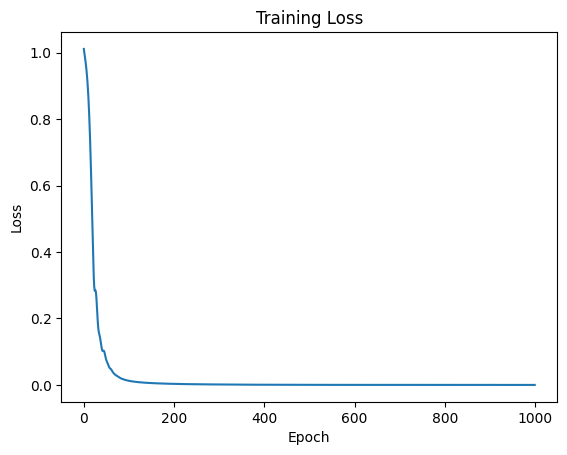

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate 2D data from a bivariate normal distribution
num_samples = 1000
mean = [0, 0]
cov = [[1, 0.2], [0.2, 1]]  # diagonal covariance
data = torch.Tensor(np.random.multivariate_normal(mean, cov, num_samples))

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
losses = []
dataloader = T.utils.data.DataLoader(normalized_training_ds, batch_size=2983, shuffle=True)

for epoch in range(num_epochs):
    # outputs = model(data)
    # loss = criterion(outputs, data)
    
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    # losses.append(loss.item())
    epoch_loss = 0.0
    for data in dataloader:
        data = data.to(device)  # Send data to GPU
        outputs = model(data)
        loss = criterion(outputs, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    losses.append(loss.item())

# Plot loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# # Visualize the results
# with torch.no_grad():
#     reconstructed_data = model(data)
#     plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), alpha=0.5, label='Original')
#     plt.scatter(reconstructed_data[:, 0].numpy(), reconstructed_data[:, 1].numpy(), alpha=0.5, label='Reconstructed')
#     plt.title("Original vs. Reconstructed Data")
#     plt.xlabel("X1")
#     plt.ylabel("X2")
#     plt.legend()
#     plt.show()



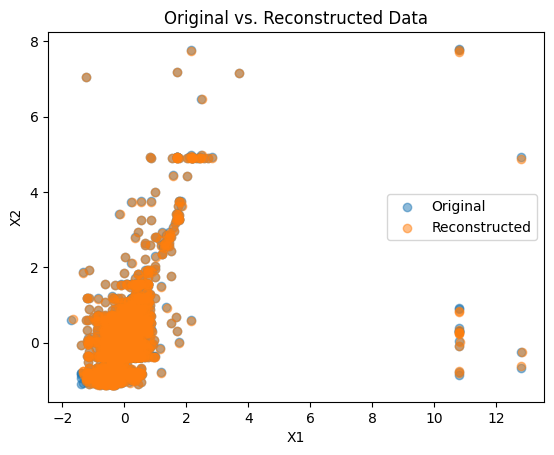

In [110]:
reconstructed_data = []
with torch.no_grad():
    for data in dataloader_eval:
        outputs = model(data)
        reconstructed_data.append(outputs)
        
    reconstructed_data = T.cat(reconstructed_data).numpy()
    plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
    plt.title("Original vs. Reconstructed Data")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()